TODO
- add directions in markdown

In [1]:
#Options
tname="TESTING"
tstamp=1 #add time stamps to output for benchmarking
stepsize=0.05 #units of g, used for bin size in histogram.  0.05 for full shipment, larger for shorter.
spec=1.5 #units of g, flag any shocks higher than this level

In [2]:
import os
import re
import sys

from datetime import datetime 
import endaq.ide as ed
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

print(f"Python Version: {sys.version}")

#Variable initialization where needed
out=[]

Python Version: 3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]


Paste in the sensor definitions from the "CM Transport instrumentation Checklist and Inventory CM<number>.xlsx as shown below and make sure all .IDE files in the format of "<SS#>_XXXX.IDE" are in the same directory as this notebook.
    
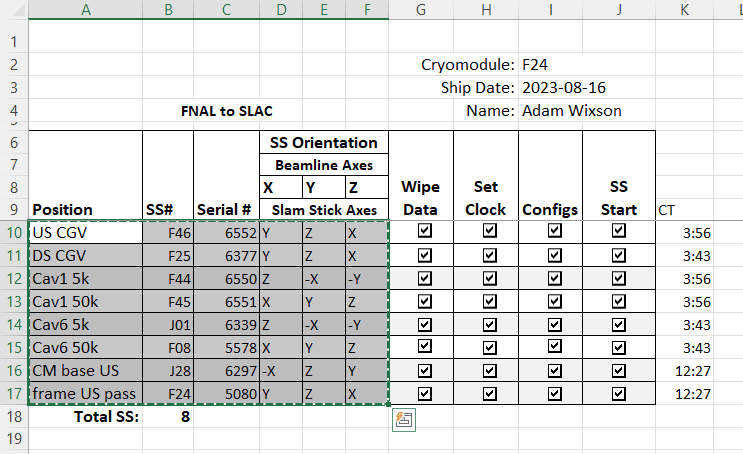

In [3]:
#Ensure pasting is done on the blank lines between the sets of """.  The """ should not have sensor data in that line.

sensor_def="""
US CGV	F46	6552	Y	Z	X
DS CGV	F25	6377	Y	Z	X
Cav1 5k	F44	6550	Z	-X	-Y
Cav1 50k	F45	6551	X	Y	Z
Cav6 5k	J01	6339	Z	-X	-Y
Cav6 50k	F08	5578	X	Y	Z
CM base US	J28	6297	-X	Z	Y
frame US pass	F24	5080	Y	Z	X
"""

#used for testing purposes
sensor_def="""
Cav6 50k	F08	5578	X	Y	Z
Inner Frame	F45	5578	Z	X	Y
"""
#Cav6 50k	F08	5578	X	Y	Z

sensors=[line.split('\t') for line in sensor_def.split('\n')]
sensors=sensors[1:len(sensors)-1]  #removes blank first and last entries from the multiline string method
print(sensors)

[['Cav6 50k', 'F08', '5578', 'X', 'Y', 'Z'], ['Inner Frame', 'F45', '5578', 'Z', 'X', 'Y']]


In [4]:
#define colors for printing
class colors: 

    reset = '\033[0m'
    bold = '\033[01m'
    disable = '\033[02m'
    underline = '\033[04m'
    reverse = '\033[07m'
    strikethrough = '\033[09m'
    invisible = '\033[08m'

    class fg:
        black = '\033[30m'
        red = '\033[31m'
        green = '\033[32m'
        orange = '\033[33m'
 
    class bg:
        black = '\033[40m'
        red = '\033[41m'
        green = '\033[42m'
        orange = '\033[43m'

In [5]:
def find_file(sensor):
    filstart=sensor[1]
    for file in os.listdir("./"):
        if file.startswith(filstart):
            filname=file
    return filname

Start at 2023-10-06 14:39:38.085499.
Opened F08_138.IDE at 2023-10-06 14:41:28.439218
Importing Cav6 50k X at: 2023-10-06 14:41:45.587935
Resampling Cav6 50k X at: 2023-10-06 14:41:51.840308
Plotting Cav6 50k X histogram at: 2023-10-06 14:41:57.942838
Plotting Cav6 50k X tseries at: 2023-10-06 14:42:07.980393
Importing Cav6 50k Y at: 2023-10-06 14:42:08.022395
Resampling Cav6 50k Y at: 2023-10-06 14:42:14.105730
Plotting Cav6 50k Y histogram at: 2023-10-06 14:42:19.898083
Plotting Cav6 50k Y tseries at: 2023-10-06 14:42:30.600660
Importing Cav6 50k Z at: 2023-10-06 14:42:30.641678
Resampling Cav6 50k Z at: 2023-10-06 14:42:36.942022
Plotting Cav6 50k Z histogram at: 2023-10-06 14:42:42.930388
Plotting Cav6 50k Z tseries at: 2023-10-06 14:42:53.273014


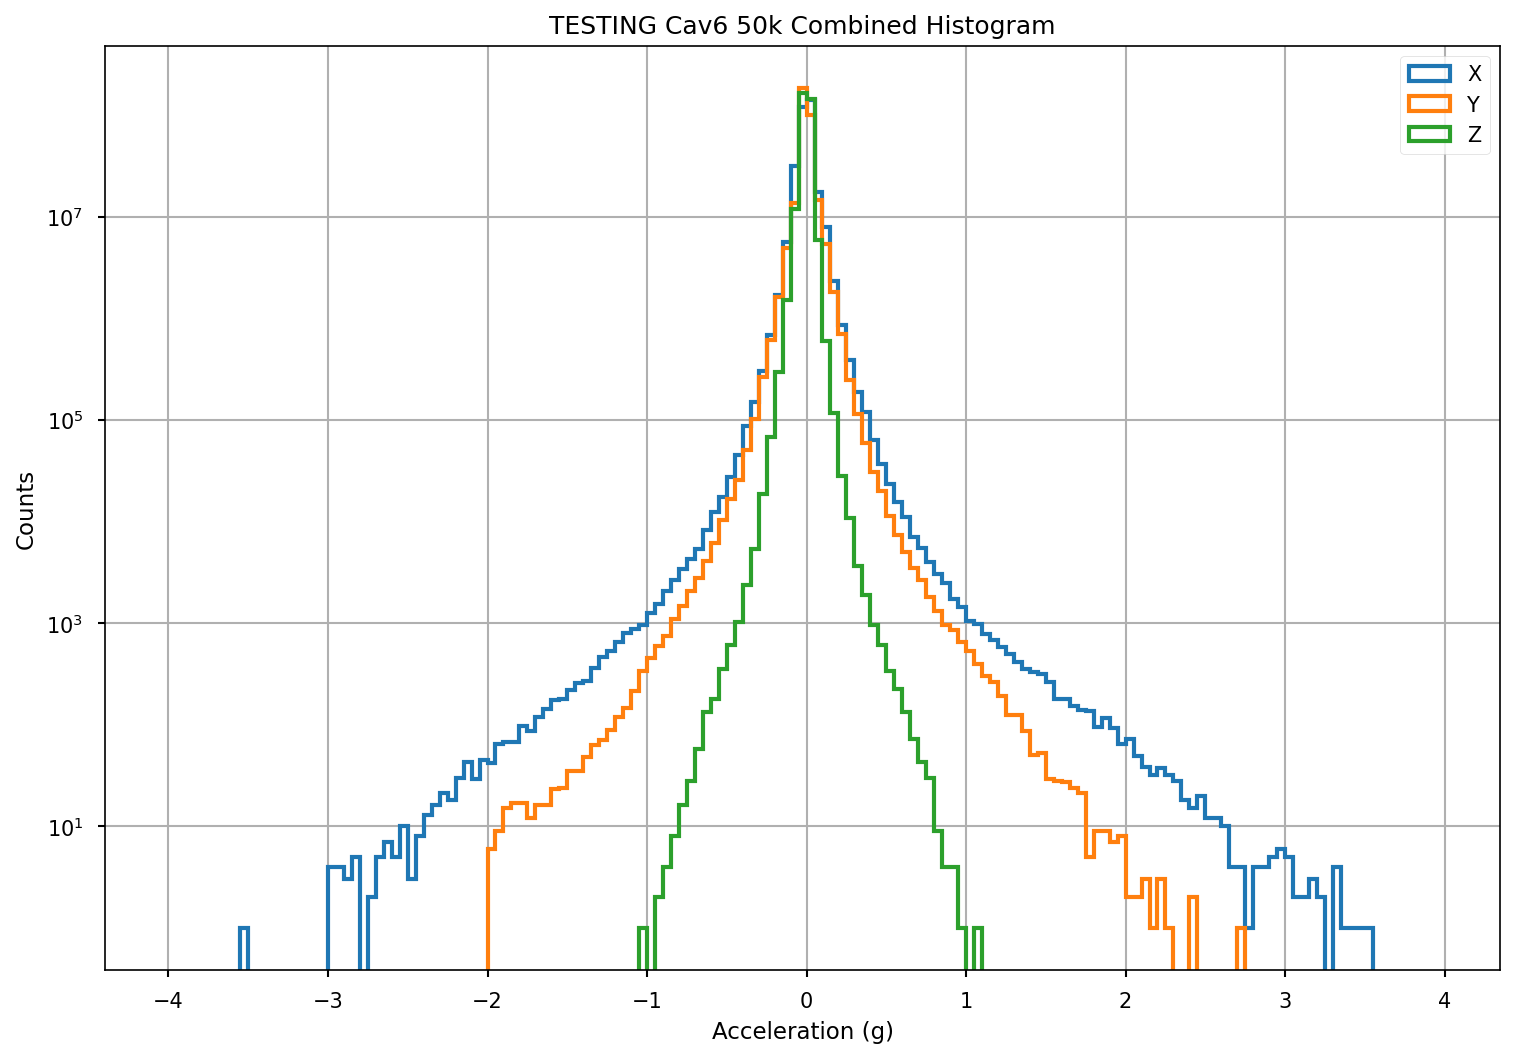

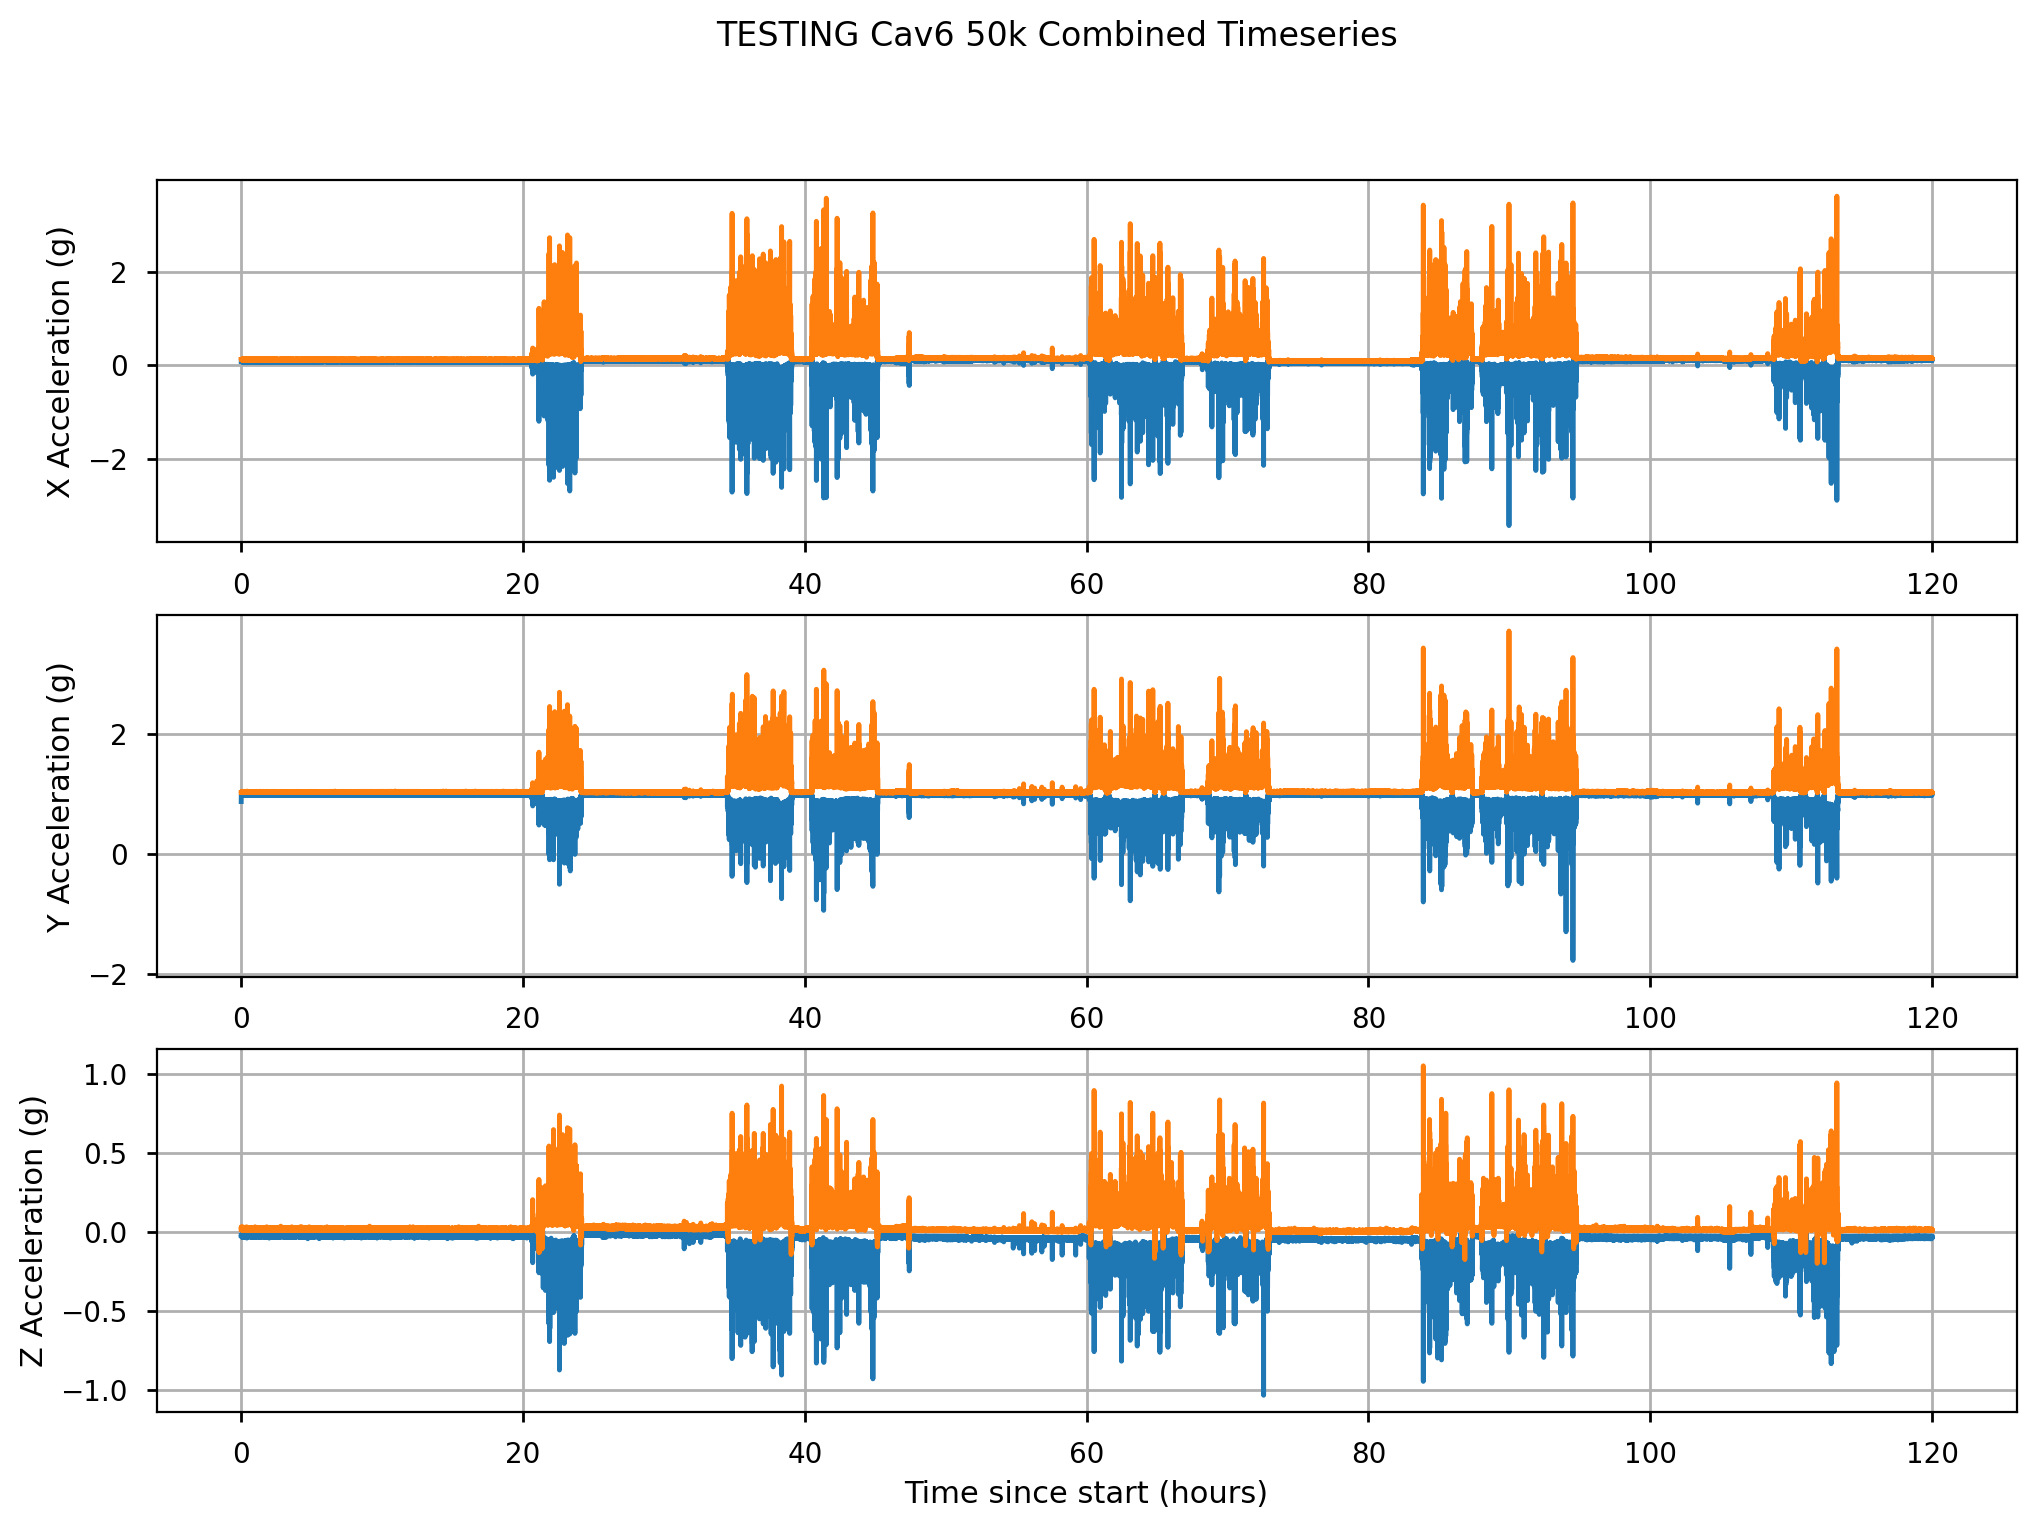

Opened F45_026.IDE at 2023-10-06 14:43:00.388226
Importing Inner Frame Z at: 2023-10-06 14:43:00.938256
Resampling Inner Frame Z at: 2023-10-06 14:43:01.160264
Plotting Inner Frame Z histogram at: 2023-10-06 14:43:01.386280
Plotting Inner Frame Z tseries at: 2023-10-06 14:43:01.784495
Importing Inner Frame X at: 2023-10-06 14:43:01.798494
Resampling Inner Frame X at: 2023-10-06 14:43:02.014507
Plotting Inner Frame X histogram at: 2023-10-06 14:43:02.230526
Plotting Inner Frame X tseries at: 2023-10-06 14:43:02.675543
Importing Inner Frame Y at: 2023-10-06 14:43:02.687543
Resampling Inner Frame Y at: 2023-10-06 14:43:02.900555
Plotting Inner Frame Y histogram at: 2023-10-06 14:43:03.111565
Plotting Inner Frame Y tseries at: 2023-10-06 14:43:03.521586


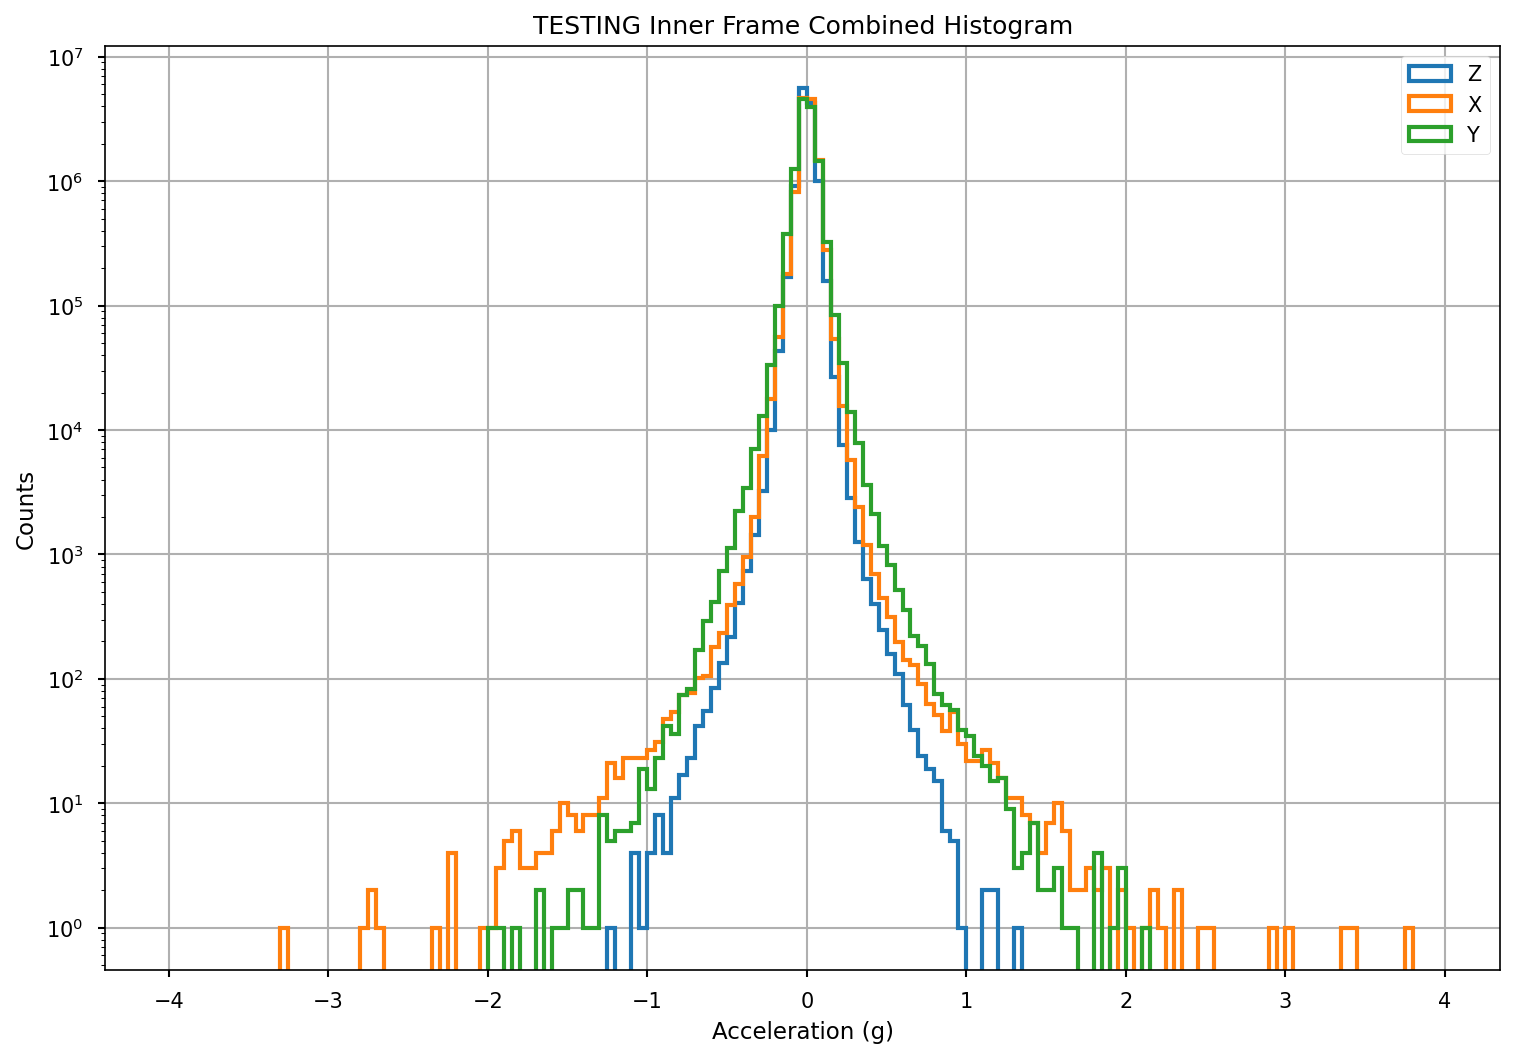

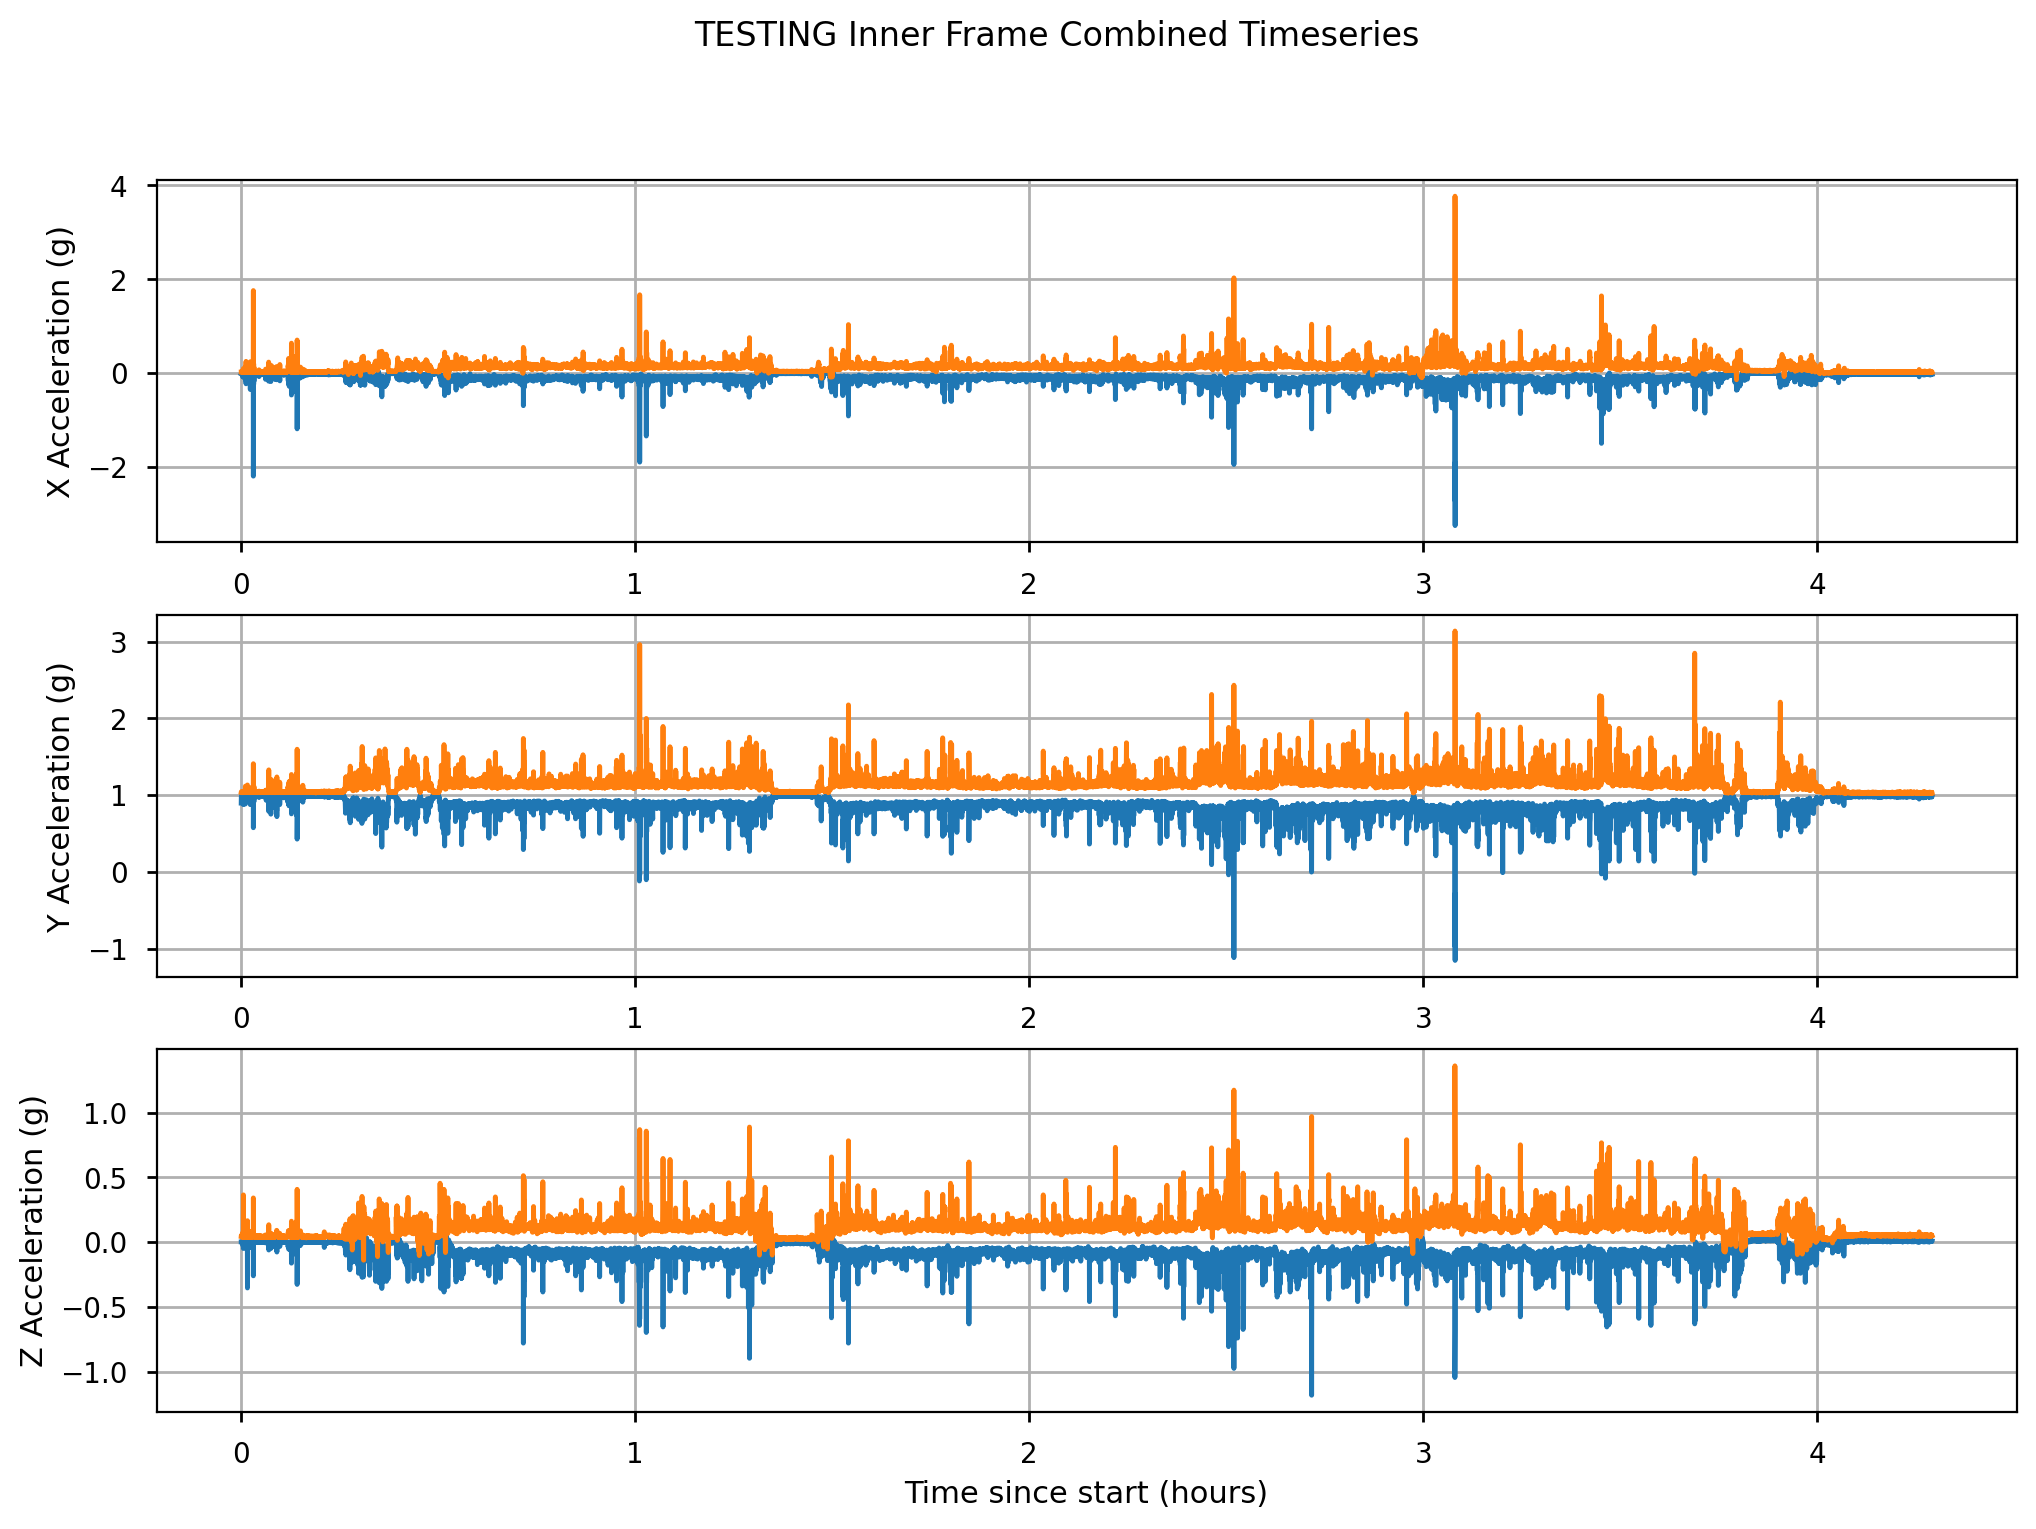

Total run time: 0:03:27.383271.


In [6]:
#Main code block

if tstamp: print(f"Start at {datetime.now()}.")
start=datetime.now()
for sensor in sensors:
    filname=find_file(sensor)
    dirs=[]
    with ed.get_doc(filname) as rawslam:
        if tstamp: print(f"Opened {filname} at {datetime.now()}")
        ed.get_channel_table(rawslam).data
        for i in range(3):  #loops over the 3 axes of channels in the data file
            if tstamp: print(f"Importing {sensor[0]} {sensor[i+3]} at: {datetime.now()}")
            accel=ed.to_pandas(ed.get_channels(rawslam, measurement_type="accel", subchannels=True)[i], time_mode='timedelta').astype(np.float32)
            
            if "-" in sensor[i+3]:  #handles inversion if needed and removing negative sign
                print(f"Needed to rotate for {sensor[0]} {sensor[i+3]}")
                accel=accel*-1
                sensor[i+3]=sensor[i+3][-1]
            
            # this defines an order for arranging the time series plots
            order={'X':0, 'Y':1, 'Z':2}
            labels=["X", "Y", "Z"]
            
            if tstamp: print(f"Resampling {sensor[0]} {sensor[i+3]} at: {datetime.now()}")
                
            #set up for time series
            #desample to 1Hz for easy plotting and analysis
            dsample=accel.resample('1s').agg(['max', 'min'])
                
            #this is unexpected behavior, why do we get mins when calling max and max when calling min?
            dsamplemin=dsample[max].to_numpy().flatten()
            dsamplemax=dsample[min].to_numpy().flatten()
            #remove DC components
            dcremovemin=dsamplemin-np.median(dsamplemin)  
            dcremovemax=dsamplemax-np.median(dsamplemax)  
            
            if i==0:
                #set up histogram plot as figure 0
                plt.figure(0,figsize=[12,8], dpi=150)
                plt.style.use('seaborn-v0_8-notebook')
                plt.xlabel("Acceleration (g)")
                plt.ylabel("Counts")

                #set up time series plots as figure 1
                gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
                plt.figure(1,figsize=[12,8], dpi=200)
                plt.style.use('seaborn-v0_8-notebook')
                plt.suptitle(f"{tname} {sensor[0]} Combined Timeseries")
            
            # plot histogram
            if tstamp: print(f"Plotting {sensor[0]} {sensor[i+3]} histogram at: {datetime.now()}")
            plt.figure(0)
            acc=accel.to_numpy().flatten()
            del accel
            bins=np.arange(np.trunc(acc.min())-1,np.trunc(acc.max())+1,stepsize)
            plt.hist(acc-np.median(acc), bins, histtype='step', log=True, lw=2, label=labels[order[sensor[i+3]]])
            del acc
            
            #plot timeseries
            if tstamp: print(f"Plotting {sensor[0]} {sensor[i+3]} tseries at: {datetime.now()}")
            time=dsample.index.to_numpy().astype(np.float32)/float(1e9)/3600 #convert to hours
            plt.figure(1)
            ax1=plt.subplot(gs[order[sensor[i+3]]])
            plt.plot(time, dsamplemin)
            plt.plot(time, dsamplemax)
            plt.grid()
            plt.ylabel(f"{labels[order[sensor[i+3]]]} Acceleration (g)")
            
            #Check criteria
            if float(dcremovemin.min()) < -spec or float(dcremovemax.max()) > spec:
                outstr=colors.fg.red + colors.bold + "WARNING! " + colors.reset + sensor[0] + " " + sensor[i+3] + " over " + str(spec) + "g specification"
                out.append(outstr)
            else:
                outstr=colors.fg.green + "OK " + colors.reset + sensor[0] + " " + sensor[i+3] + " GOOD."
                out.append(outstr)
        
        #finish up some things on the histogram plot
        plt.figure(0)
        plt.xlabel("Acceleration (g)")
        plt.ylabel("Counts")
        plt.legend()
        plt.grid()
        plt.title(f"{tname} {sensor[0]} Combined Histogram")
        plt.savefig(f"{tname} {sensor[0]} Combined Histogram.png", bbox_inches="tight", dpi=150)
        
        #finish up some things on the time series plots
        plt.figure(1)
        ax1=plt.subplot(gs[2])
        plt.xlabel("Time since start (hours)")
        plt.savefig(f"{tname} {sensor[0]} Combined Timeseries.png", bbox_inches="tight", dpi=150)
        
        plt.show()
        plt.close()
        
if tstamp: print(f"Total run time: {datetime.now()-start}.")

In [7]:
#Print the summary output

for line in out:
    print(line)

WARNING! Cav6 50k X over 1.5g specification
WARNING! Cav6 50k Y over 1.5g specification
OK Cav6 50k Z GOOD.
OK Inner Frame Z GOOD.
WARNING! Inner Frame X over 1.5g specification
WARNING! Inner Frame Y over 1.5g specification
